In [ ]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn

from google.colab import drive
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from cyclic_lr_scheduler import CyclicLR

Mounted at /content/drive


In [ ]:
class ConfigTuring:
    T = 100.0
    T_unit = 1
    T_N = int(T / T_unit)

    NN = 100
    MM = 1

    alpha = 1
    beta = 0.3
    gamma = 0.3
    b = 0.5
    c = 0.6
    m = 0.6
    q = 0.35
    d1 = 0.015
    d2 = 1

    s = 3.00  # 1.75, 1.9, 2.0, 2.45, 3.0

    l = 1
    w = 1

    np.random.seed(0)

    u_0 = np.random.rand(NN, MM).reshape([NN * MM])
    v_0 = np.random.rand(NN, MM).reshape([NN * MM])
    y_0 = np.concatenate([u_0, v_0])

    ub = T
    lb = 0.0


def block_design_a(network_unit, sig):
    return nn.Sequential((OrderedDict({
      'lin1': nn.Linear(1, network_unit),
      'sig1': sig,
      'lin2': nn.Linear(network_unit, network_unit),
      'sig2': sig,
      'lin3': nn.Linear(network_unit, network_unit),
      'sig3': sig,
      'lin4': nn.Linear(network_unit, 1),
    })))

class SimpleNetworkTuring(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkTuring, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkTuring"
        self.sig = nn.Tanh()
        self.network_unit = 1
        self.sequences_u = []
        self.sequences_v = []

        # Design A

        u_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.NN)]
        v_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.NN)]

        self.sequences_u = nn.Sequential(*u_blocks)
        self.sequences_v = nn.Sequential(*v_blocks)

        # self.encoder = nn.Sequential(*conv_blocks)
        # for i in range(self.config.NN):
        #   self.sequences_u.append(nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(self.network_unit, self.network_unit),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(self.network_unit, self.network_unit),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(self.network_unit, 1),
        #   })))
        #   self.sequences_v.append(nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(self.network_unit, self.network_unit),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(self.network_unit, self.network_unit),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(self.network_unit, 1),
        #   })))


    def forward(self, inputs):
        # print(inputs.shape)
        # print("inputs=", inputs)
        # print("forward inputs shape:", inputs.shape)
        u_input, v_input = inputs[:, :self.config.NN * self.config.MM], inputs[:, self.config.NN * self.config.MM:]
        # print("u_input shape:", u_input.shape)
        # print("v_input shape:", v_input.shape)
        u_output, v_output = [], []
        
        # Design A
        
        for i in range(self.config.NN):
          u_output.append(self.sequences_u[i](u_input[:,i:i+1]))
          v_output.append(self.sequences_v[i](v_input[:,i:i+1]))
        u_output = torch.cat(tuple(item for item in u_output), 1)
        v_output = torch.cat(tuple(item for item in v_output), 1)

        outputs = torch.cat((u_output, v_output), 1)
        # print("forward outputs shape:",outputs.shape)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit] * (self.config.NN * 2) for i in range(self.config.T_N)]
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)
        # print("self.x shape:", self.x.shape)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0] * (2 * self.config.NN)).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(self.config.y_0.reshape([1, -1])).float().to(self.device)

    def loss(self):
        self.eval()
        y = self.forward(self.x)
        # print("y shape:", y.shape)

        u = y[:, :self.config.NN * self.config.MM]
        v = y[:, self.config.NN * self.config.MM:]

        u_t_collection, v_t_collection = [], []
        for ii in range(self.config.NN):
          u_t_collection.append(torch.gradient(u[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))
          v_t_collection.append(torch.gradient(v[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))
        u_t = torch.cat(u_t_collection, 1)
        v_t = torch.cat(v_t_collection, 1)


        u_from_left = torch.roll(u, 1, 1)
        u_from_left[:, :1] = u[:, :1]
        u_from_right = torch.roll(u, -1, 1)
        u_from_right[:, -1:] = u[:, -1:]

        v_from_left = torch.roll(v, 1, 1)
        v_from_left[:, :1] = v[:, :1]
        v_from_right = torch.roll(v, -1, 1)
        v_from_right[:, -1:] = v[:, -1:]

        u_diffusion = self.config.d1 * ((u_from_left + u_from_right - u * 2) / (self.config.l ** 2))
        v_diffusion = self.config.d2 * ((v_from_left + v_from_right - v * 2) / (self.config.l ** 2))

        u_reaction = u * (self.config.alpha - self.config.beta * u - self.config.q / (u + self.config.b)) - self.config.c * u * v / (self.config.m * v + 1)
        v_reaction = v * (-self.config.gamma + self.config.s * u / (self.config.m * v + 1))

        u_t_target = u_diffusion + u_reaction
        v_t_target = v_diffusion + v_reaction

        f_u = u_t - u_t_target
        f_v = v_t - v_t_target
        
        f_y = torch.cat((f_u, f_v), 1)
        y0_pred = self.forward(self.t0)
        
        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        # loss_3 = torch.mean(torch.square((torch.abs(s) - s))) + torch.mean(torch.square((torch.abs(i) - i))) + torch.mean(torch.square((torch.abs(r) - r))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(0.00001 / ((s * s + i * i) * (i * i + r * r) * (s * s + r * r) + 1e-8)))

        # 04/27 TODO: re-design the loss functions. I want to do it but Chen asked me to implement new models. Now it's your turn.

        loss = loss_1 + loss_2 # + loss_3 + loss_4
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_2]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [ ]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def draw_turing(u, v, config, save_flag=False, save_path=None):

    fig = plt.figure(figsize=(24, 9))

    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(u, cmap=plt.cm.jet, vmin=u[:,-1:].min(), vmax=u[:,-1:].max(), aspect='auto')
    ax1.set_title("u (s={0:.2f})".format(config.s))
    cb1 = plt.colorbar(im1, shrink=1)

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(v, cmap=plt.cm.jet, vmin=v[:,-1:].min(), vmax=v[:,-1:].max(), aspect='auto')
    ax2.set_title("v (s={0:.2f})".format(config.s))
    cb2 = plt.colorbar(im2, shrink=1)
    plt.tight_layout()
    if save_flag:
        plt.savefig(save_path, dpi=300)
    plt.show()
    plt.clf()

def train_turing(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            now_time = time.time()
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_turing(model, args, config, now_string, True)

def test_turing(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    u, v = y[:, :model.config.NN * model.config.MM], y[:, model.config.NN * model.config.MM:]
    u = u.cpu().detach().numpy().swapaxes(0, 1)
    v = v.cpu().detach().numpy().swapaxes(0, 1)
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}.png"
    draw_turing(u, v, model.config, True, figure_save_path)


class Args:
  epoch = 100000
  epoch_step = 100
  lr = 0.001
  main_path = "."
  save_step = 1000

def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

def run_turing(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigTuring
    model = SimpleNetworkTuring(config).to(device)
    train_turing(model, args, config, now_string)
    model = SimpleNetworkTuring(config).to(device)
    test_turing(model, args, config, now_string)

using cuda
epoch = 100000
epoch_step = 100
model_name = SimpleNetworkTuring
now_string = 2022-04-30-01-12-17
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_100000_100_0.001_2022-04-30-01-12-17_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkTuring_100000_100_0.001_2022-04-30-01-12-17_best.pt
Epoch [00100/100000] Loss:2.927752 Loss_1:0.568868 Loss_2:2.358884 Loss_3:2.358884 Lr:0.000990 Time:71.951876s (1.20min in total)
Epoch [00200/100000] Loss:1.765968 Loss_1:0.484540 Loss_2:1.281428 Loss_3:1.281428 Lr:0.000980 Time:72.455710s (2.41min in total)
Epoch [00300/100000] Loss:1.278052 Loss_1:0.428550 Loss_2:0.849501 Loss_3:0.849501 Lr:0.000971 Time:72.195695s (3.61min in total)
Epoch [00400/100000] Loss:1.026367 Loss_1:0.383654 Loss_2:0.642713 Loss_3:0.642713 Lr:0.000962 Time:71.947366s (4.81min in total)
Epoch [00500/100000] Loss:0.883179 Loss_1:0.346923 Loss_2:0.536256 Loss_3:0.536256 Lr:0.000952 Time:72.47

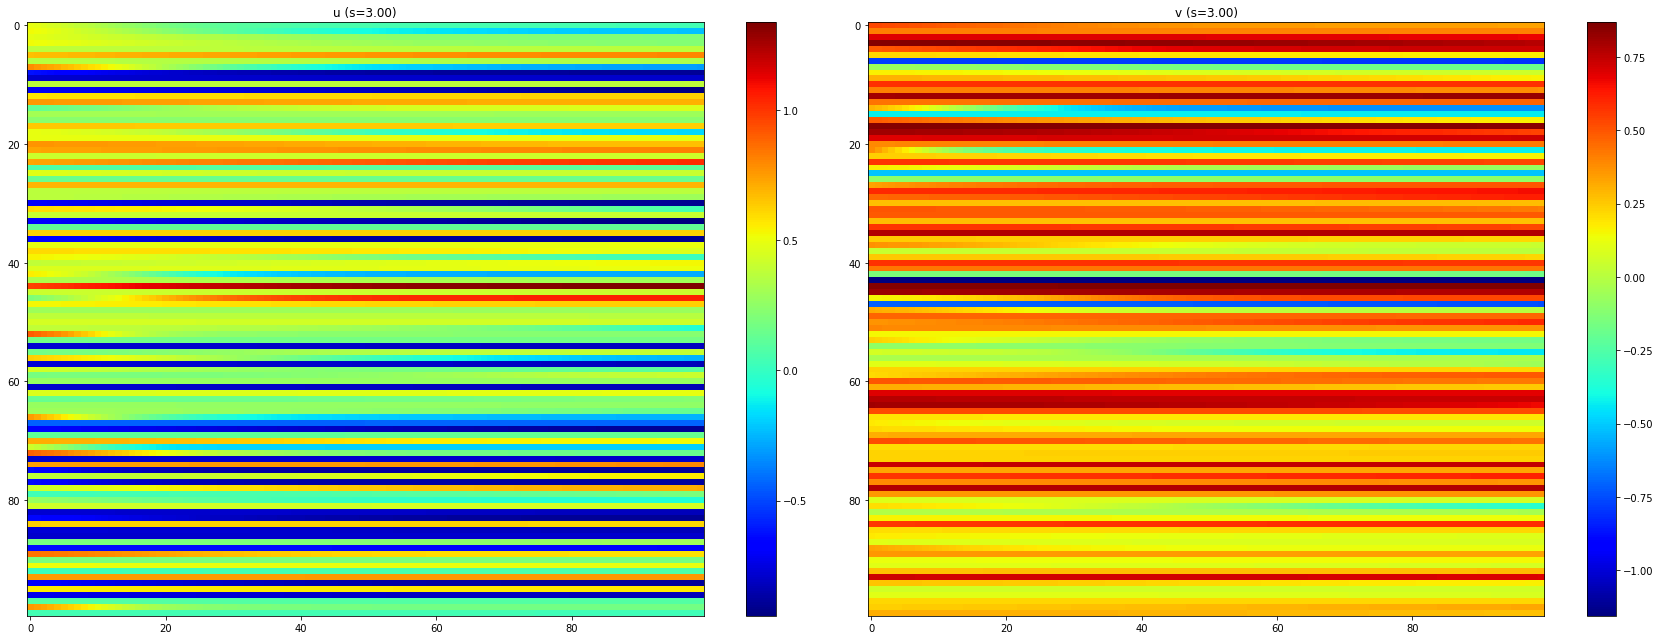

Epoch [01100/100000] Loss:0.631232 Loss_1:0.236296 Loss_2:0.394936 Loss_3:0.394936 Lr:0.000901 Time:77.531070s (13.32min in total)
Epoch [01200/100000] Loss:0.617207 Loss_1:0.228596 Loss_2:0.388610 Loss_3:0.388610 Lr:0.000893 Time:71.904444s (14.52min in total)
Epoch [01300/100000] Loss:0.605156 Loss_1:0.222065 Loss_2:0.383092 Loss_3:0.383092 Lr:0.000885 Time:71.623739s (15.71min in total)
Epoch [01400/100000] Loss:0.594363 Loss_1:0.215994 Loss_2:0.378369 Loss_3:0.378369 Lr:0.000877 Time:71.580652s (16.91min in total)
Epoch [01500/100000] Loss:0.584473 Loss_1:0.210046 Loss_2:0.374428 Loss_3:0.374428 Lr:0.000870 Time:72.045703s (18.11min in total)
Epoch [01600/100000] Loss:0.575581 Loss_1:0.204816 Loss_2:0.370765 Loss_3:0.370765 Lr:0.000862 Time:72.034708s (19.31min in total)
Epoch [01700/100000] Loss:0.567567 Loss_1:0.200192 Loss_2:0.367375 Loss_3:0.367375 Lr:0.000855 Time:71.619989s (20.50min in total)
Epoch [01800/100000] Loss:0.560329 Loss_1:0.196156 Loss_2:0.364173 Loss_3:0.364173 

<Figure size 432x288 with 0 Axes>

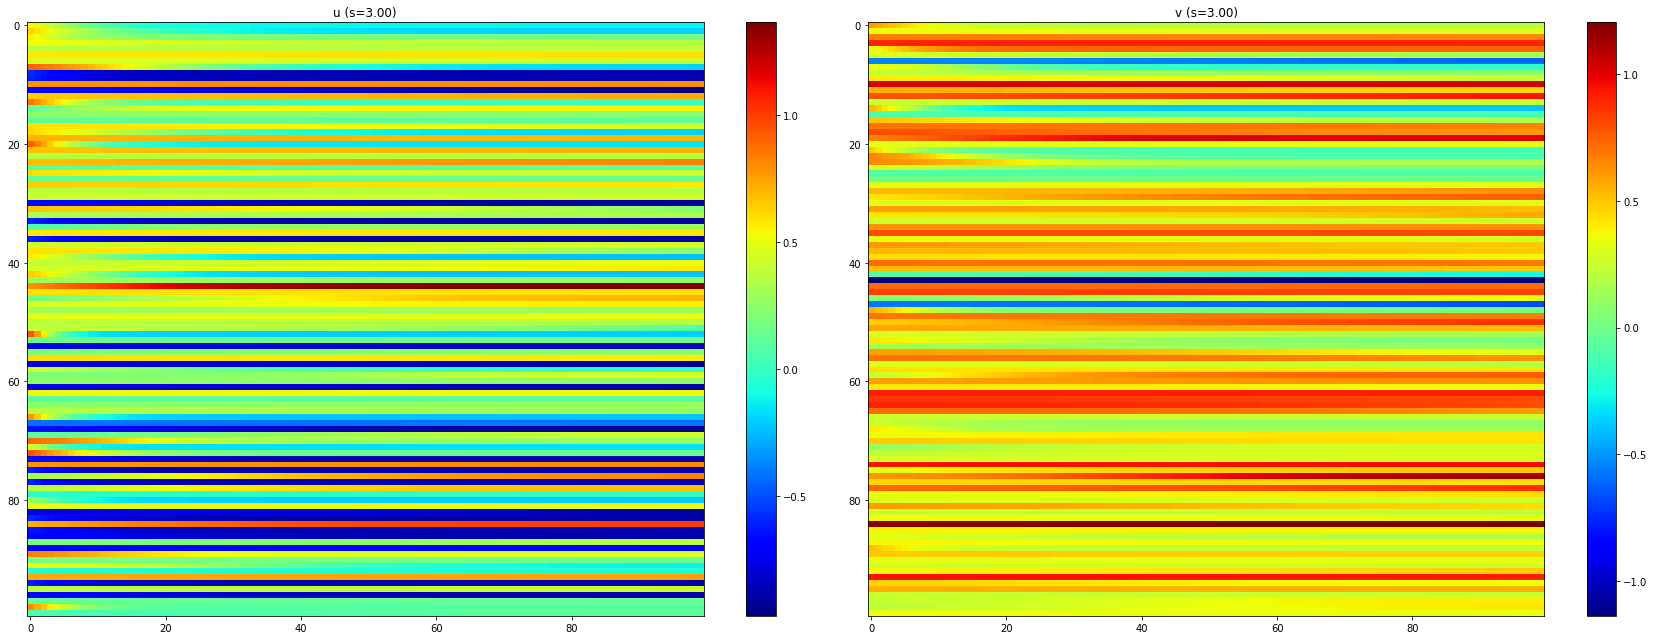

Epoch [02100/100000] Loss:0.541631 Loss_1:0.186435 Loss_2:0.355196 Loss_3:0.355196 Lr:0.000826 Time:76.099267s (25.36min in total)
Epoch [02200/100000] Loss:0.535686 Loss_1:0.183520 Loss_2:0.352166 Loss_3:0.352166 Lr:0.000820 Time:71.059544s (26.54min in total)
Epoch [02300/100000] Loss:0.529757 Loss_1:0.179956 Loss_2:0.349801 Loss_3:0.349801 Lr:0.000813 Time:71.331872s (27.73min in total)
Epoch [02400/100000] Loss:0.524584 Loss_1:0.177332 Loss_2:0.347253 Loss_3:0.347253 Lr:0.000806 Time:71.517753s (28.93min in total)
Epoch [02500/100000] Loss:0.519776 Loss_1:0.174939 Loss_2:0.344837 Loss_3:0.344837 Lr:0.000800 Time:71.491757s (30.12min in total)
Epoch [02600/100000] Loss:0.515166 Loss_1:0.172722 Loss_2:0.342444 Loss_3:0.342444 Lr:0.000794 Time:71.173803s (31.30min in total)
Epoch [02700/100000] Loss:0.510792 Loss_1:0.170762 Loss_2:0.340030 Loss_3:0.340030 Lr:0.000787 Time:71.370930s (32.49min in total)
Epoch [02800/100000] Loss:0.506562 Loss_1:0.168940 Loss_2:0.337622 Loss_3:0.337622 

<Figure size 432x288 with 0 Axes>

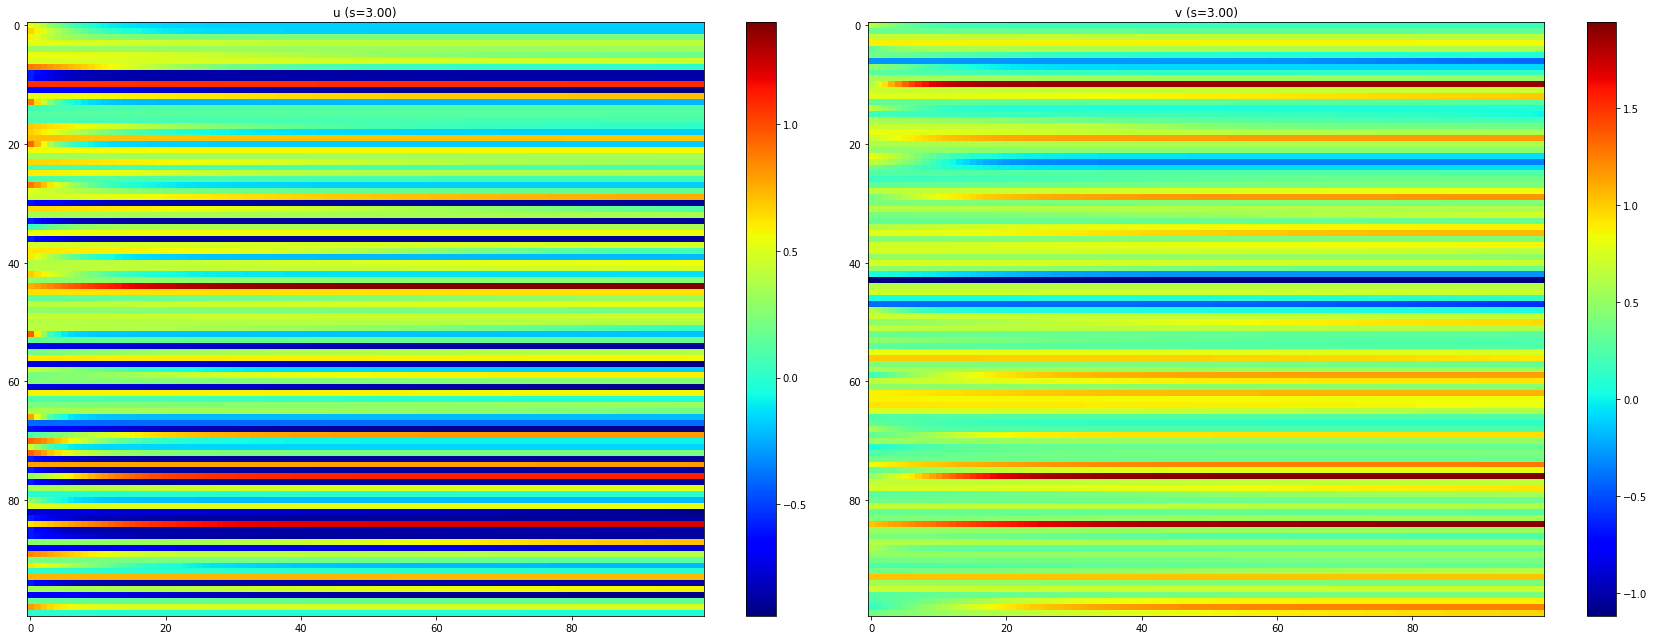

In [ ]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_turing(main_path)

In [ ]:
uu = np.asarray([[3,2,1.1], [4,5,2.1]])
vv = np.asarray([[3,2,1.1], [4,5,2.1]])
config = ConfigTuring
draw_turing(uu, vv, config)

In [ ]:
# SIR Ages - Design D
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigTuring
model = SimpleNetworkTuring(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=10)


# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sir_ages(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

using cuda
epoch = 200
epoch_step = 10
model_name = SimpleNetworkSIS
now_string = 2022-04-05-04-23-59
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy
Epoch [00010/00200] Loss:4.385890 Loss_1:0.993828 Loss_2:3.392061 Loss_3:0.000000 Lr:0.000990 Time:20.769258s (0.35min in total)
Epoch [00020/00200] Loss:0.537250 Loss_1:0.001285 Loss_2:0.535965 Loss_3:0.000000 Lr:0.000980 Time:21.398914s (0.70min in total)
Epoch [00030/00200] Loss:0.199641 Loss_1:0.000367 Loss_2:0.199275 Loss_3:0.000000 Lr:0.000971 Time:21.223898s (1.06min in total)
Epoch [00040/00200] Loss:0.028498 Loss_1:0.000046 Loss_2:0.028452 Loss_3:0.000000 Lr:0.000962 Time:24.785387

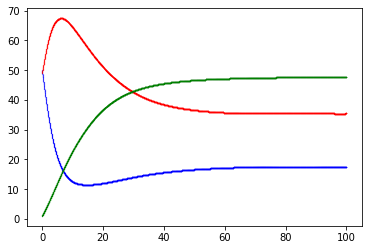

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_1649132828.png


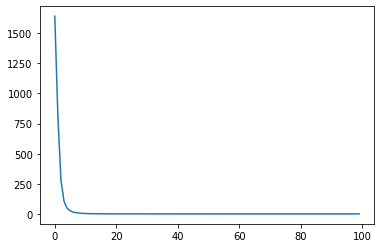

Epoch [00110/00200] Loss:0.000316 Loss_1:0.000001 Loss_2:0.000315 Loss_3:0.000000 Lr:0.000901 Time:8.971978s (3.30min in total)
Epoch [00120/00200] Loss:0.000314 Loss_1:0.000002 Loss_2:0.000313 Loss_3:0.000000 Lr:0.000893 Time:7.095406s (3.41min in total)
Epoch [00130/00200] Loss:0.000313 Loss_1:0.000002 Loss_2:0.000310 Loss_3:0.000000 Lr:0.000885 Time:10.209145s (3.58min in total)
Epoch [00140/00200] Loss:0.000312 Loss_1:0.000002 Loss_2:0.000309 Loss_3:0.000000 Lr:0.000877 Time:9.002768s (3.73min in total)
Epoch [00150/00200] Loss:0.000310 Loss_1:0.000002 Loss_2:0.000308 Loss_3:0.000000 Lr:0.000870 Time:8.333244s (3.87min in total)
Epoch [00160/00200] Loss:0.000310 Loss_1:0.000002 Loss_2:0.000308 Loss_3:0.000000 Lr:0.000862 Time:7.819227s (4.00min in total)
Epoch [00170/00200] Loss:0.000309 Loss_1:0.000002 Loss_2:0.000307 Loss_3:0.000000 Lr:0.000855 Time:6.170593s (4.11min in total)
Epoch [00180/00200] Loss:0.000308 Loss_1:0.000002 Loss_2:0.000306 Loss_3:0.000000 Lr:0.000847 Time:6.36

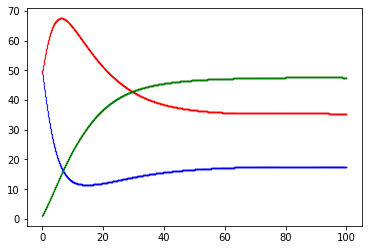

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_1649132905.png


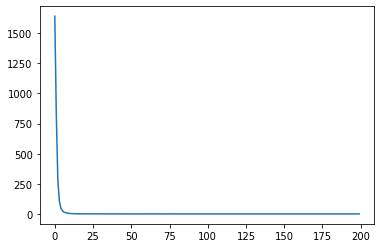

<Figure size 432x288 with 0 Axes>

In [ ]:
# SIR Ages - Design D
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIS
model = SimpleNetworkSIS(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sis(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

using cuda
epoch = 200
epoch_step = 10
model_name = SimpleNetworkSIS
now_string = 2022-04-05-04-31-58
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy
Epoch [00010/00200] Loss:5.631307 Loss_1:0.620286 Loss_2:5.011021 Loss_3:0.000000 Lr:0.000990 Time:18.105077s (0.30min in total)
Epoch [00020/00200] Loss:0.732931 Loss_1:0.001460 Loss_2:0.731471 Loss_3:0.000000 Lr:0.000980 Time:19.640622s (0.63min in total)
Epoch [00030/00200] Loss:0.246524 Loss_1:0.000319 Loss_2:0.246205 Loss_3:0.000000 Lr:0.000971 Time:19.177369s (0.95min in total)
Epoch [00040/00200] Loss:0.037348 Loss_1:0.000042 Loss_2:0.037306 Loss_3:0.000000 Lr:0.000962 Time:18.565581

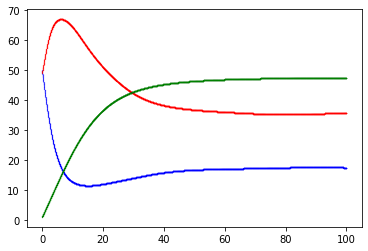

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_1649133302.png


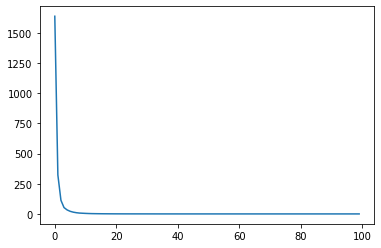

Epoch [00110/00200] Loss:0.001332 Loss_1:0.000002 Loss_2:0.001330 Loss_3:0.000000 Lr:0.000901 Time:12.406436s (3.27min in total)
Epoch [00120/00200] Loss:0.001329 Loss_1:0.000004 Loss_2:0.001325 Loss_3:0.000000 Lr:0.000893 Time:11.614854s (3.47min in total)
Epoch [00130/00200] Loss:0.001329 Loss_1:0.000006 Loss_2:0.001324 Loss_3:0.000000 Lr:0.000885 Time:9.250310s (3.62min in total)
Epoch [00140/00200] Loss:0.001328 Loss_1:0.000006 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000877 Time:9.061673s (3.77min in total)
Epoch [00150/00200] Loss:0.001328 Loss_1:0.000005 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000870 Time:8.065998s (3.91min in total)
Epoch [00160/00200] Loss:0.001328 Loss_1:0.000005 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000862 Time:10.895294s (4.09min in total)
Epoch [00170/00200] Loss:0.001327 Loss_1:0.000004 Loss_2:0.001323 Loss_3:0.000000 Lr:0.000855 Time:11.236281s (4.28min in total)
Epoch [00180/00200] Loss:0.001325 Loss_1:0.000003 Loss_2:0.001322 Loss_3:0.000000 Lr:0.000847 Time:8

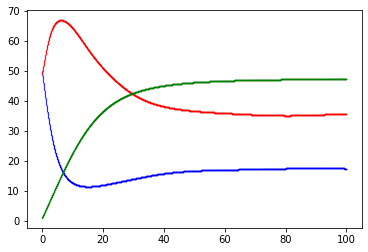

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_1649133401.png


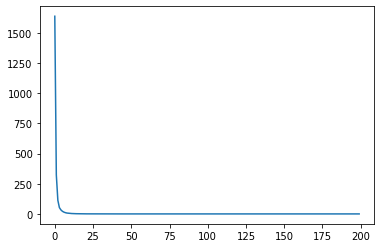

<Figure size 432x288 with 0 Axes>

In [ ]:
# SIR Ages - Design A
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIRAges
model = SimpleNetworkSIRAges(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sir_ages(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

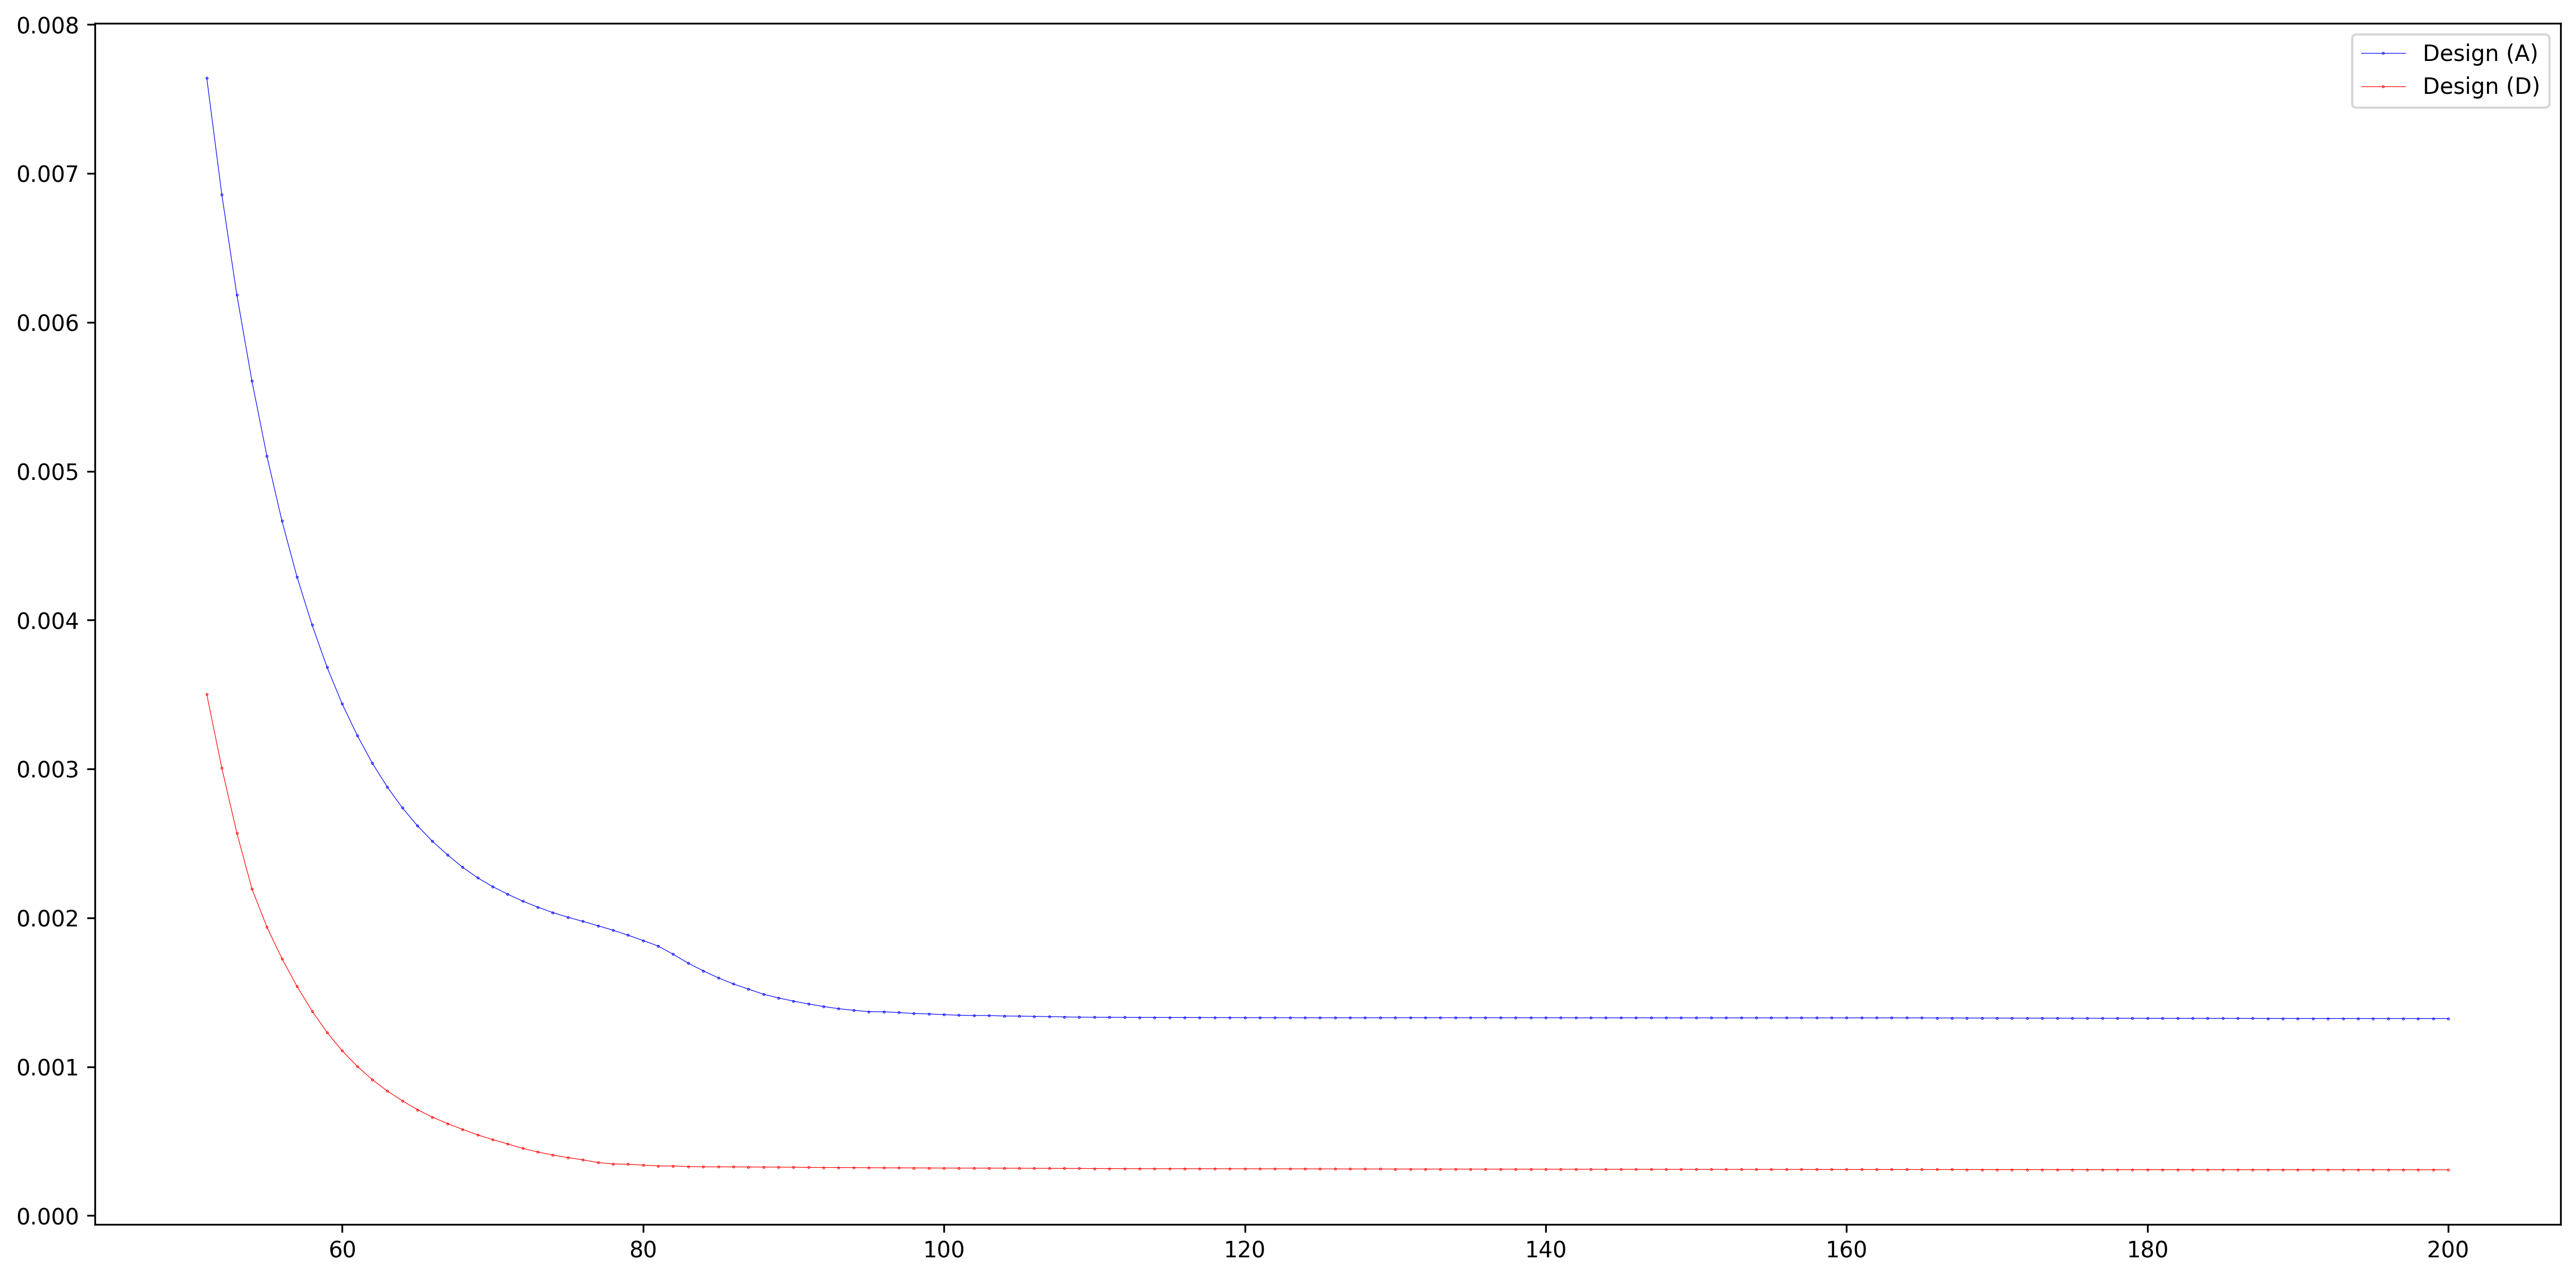

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
import numpy as np
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy")
loss_d = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy")

start = 50
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=300, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.5, linewidth=0.3, c="b")
plt.plot(x, loss_d[start:], marker='.', markersize=0.5, linewidth=0.3, c="r")
plt.legend(["Design (A)","Design (D)"])
plt.show()
plt.clf()